# Building automated chest radiograph interpretation application

### by Phuong T.M. Chu
<p align="center">
<img width="360" height="300" src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Projectional_rendering_of_CT_scan_of_thorax_%28thumbnail%29.gif/358px-Projectional_rendering_of_CT_scan_of_thorax_%28thumbnail%29.gif">
</p>

In [1]:
#!pip install tensorflow-gpu==2.0.0-rc1
import tensorflow as tf
tf.__version__

'2.0.0-rc1'

In [2]:
#from tensorflow import keras

# Working with directory library
from os import path, listdir
from os.path import isdir

# Image visualization
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import shutil # copy, move file
import os # miscellaneous operation system interfaces
import pathlib
import random
import cv2
from PIL import Image

In [4]:
label = pd.read_csv("./CheXpert-v1.0-small/train.csv")
label = label.fillna(0)
label = label.drop(columns =['Sex','Age','Frontal/Lateral','AP/PA'])
label.head()

,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Uncertainty Approaches

The CheXpert paper outlines several different approaches to mapping using the uncertainty labels in the data:

- Ignoring - essentially removing from the calculation in the loss function
- Binary mapping - sending uncertain values to either 0 or 1
- Prevalence mapping - use the rate of prevelance of the feature as it's target value
- Self-training - consider the uncertain values as unlabeled
- 3-Class Classification - retain a separate value for uncertain and try to predict it as a class in its own right

The binary mapping approaches (U-Ones and U-Zeros) are easiest to implement and so to begin with we take the best option between U-Ones and U-Zeros for each feature.

In [6]:
u_zeros = ["No Finding","Enlarged Cardiomediastinum","Cardiomegaly",
           "Consolidation","Pneumonia","Pneumothorax","Pleural Other"]
u_ones = ["Atelectasis", "Edema","Pleural Effusion","Lung Opacity","Lung Lesion",
          "Fracture","Support Devices"]

for obs0 in u_zeros:
    label[obs0][label[obs0] == -1] = 0 # change label -1 to label 0
for obs1 in u_ones:
    label[obs1][label[obs1] == -1] = 1 # change label -1 to label 0
    
label.head()

,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Load  and preprocess images

In [7]:
IMAGE_SIZE = (331,331)

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [8]:
from sklearn.model_selection import train_test_split

all_image_labels = []
for i, row in label.iterrows():
    all_image_labels.append(list(row[1:]))

all_image_paths = list(label["Path"])

image_count = len(all_image_paths)

train_image_paths, test_image_paths, train_image_labels, test_image_labels = train_test_split(all_image_paths, 
                                                                                              all_image_labels, 
                                                                                              test_size=0.1, 
                                                                                              random_state=101)

In [10]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [11]:
from keras_preprocessing.image import ImageDataGenerator

observations = ['No Finding','Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity','Lung Lesion', 
                 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis','Pneumothorax', 'Pleural Effusion', 
                 'Pleural Other', 'Fracture','Support Devices']

train_set = label[label["Path"].isin(train_image_paths)]
test_set = label[label["Path"].isin(test_image_paths)]

train_datagen = ImageDataGenerator(rescale=1./255, 
                                    featurewise_std_normalization=True,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.15,
                                    shear_range=0.15,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest")

train_generator = train_datagen.flow_from_dataframe(dataframe=train_set, 
                                            directory=None, 
                                            x_col='Path', 
                                            y_col=observations, 
                                            target_size= IMAGE_SIZE, 
                                            class_mode="other",
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True,
                                            interpolation='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_set, 
                                            directory=None, 
                                            x_col='Path', 
                                            y_col=observations, 
                                            target_size= IMAGE_SIZE, 
                                            class_mode="other",
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True,
                                            interpolation='nearest')

Found 201072 validated image filenames.
Found 22342 validated image filenames.


## BUILDING MODEL
### CUSTOMIZE CALLBACK

In [14]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
#         self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['accuracy'])
#         self.model.reset_metrics()

In [21]:
steps_per_epoch = tf.math.ceil(0.9 * image_count/BATCH_SIZE).numpy()
val_steps_per_epoch = tf.math.ceil(0.1 * image_count/BATCH_SIZE).numpy()
batch_stats_callback = CollectBatchStats() #if you keep it, the model will train again from the beginning when restart cells

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss='binary_crossentropy',
              metrics=["accuracy","AUC"])

history = model.fit(train_generator, epochs=1, 
            steps_per_epoch=steps_per_epoch,
            callbacks = [batch_stats_callback],
            validation_data=test_generator,
            validation_steps=val_steps_per_epoch)

6284/6284 [==============================] - 3227s 514ms/step - loss: 0.3063 - accuracy: 0.8703 - AUC: 0.8857 - val_loss: 0.3154 - val_accuracy: 0.8645 - val_AUC: 0.8817


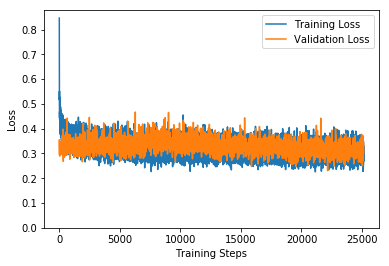

In [23]:
def plot_loss(training_losses, val_losses, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Loss")
    plt.xlabel(x_label)
    
    training_steps = len(training_losses)
    test_steps = len(val_losses)
    plt.plot(training_losses, label='Training Loss')
    plt.plot(np.linspace(0, training_steps, test_steps), val_losses, label='Validation Loss')
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc='upper right')
    plt.show()
    
plot_loss(batch_stats_callback.batch_losses, batch_stats_callback.batch_val_losses)

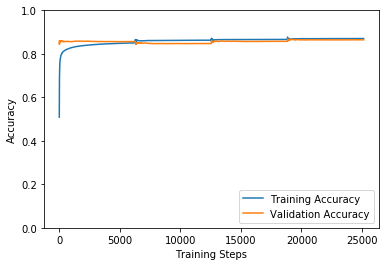

In [24]:
def plot_accuracy(training_acc, val_acc, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Accuracy")
    plt.xlabel(x_label)
    
    training_steps = len(training_acc)
    test_steps = len(val_acc)
    plt.plot(training_acc, label='Training Accuracy')
    plt.plot(np.linspace(0, training_steps, test_steps), val_acc, label='Validation Accuracy')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.show()
    
plot_accuracy(batch_stats_callback.batch_acc, batch_stats_callback.batch_val_acc)

### SAVING MODEL

In [22]:
model.save('model.h5')

### MAKING PREDICTION

In [46]:
from tensorflow.keras.models import load_model

reloaded_model = load_model('model.h5')
reloaded_model.summary()

W1002 18:17:52.069764 140439676405568 deprecation.py:506] From /home/reichu2/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [14]:
IMAGE_SIZE = (224,224)

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image /= 255.0  # normalize to [0,1] range
    #image = 2*image-1  # normalize to [-1,1] range for MobileNet

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

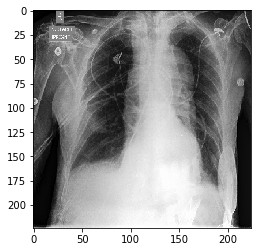

In [12]:
import vis

img_path = 'CheXpert-v1.0-small/valid/patient64740/study1/view1_frontal.jpg'

_img = tf.keras.preprocessing.image.load_img(img_path,target_size=(224,224))
plt.imshow(_img)
plt.show()

In [15]:
img = load_and_preprocess_image(img_path)
y_pred = reloaded_model.predict([[img]])

In [16]:
y_pred

array([[0.02646688, 0.11636689, 0.16192326, 0.5435303 , 0.04843828,
        0.07396001, 0.03858024, 0.01073283, 0.38122135, 0.18305379,
        0.54414845, 0.01624384, 0.06505421, 0.41315758]], dtype=float32)

In [17]:
observations = ['No Finding','Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity','Lung Lesion', 
                 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis','Pneumothorax', 'Pleural Effusion', 
                 'Pleural Other', 'Fracture','Support Devices']
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
topNclass         = 5
for i, idx in enumerate(class_idxs_sorted[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,observations[idx],idx,y_pred[0,idx]))

Top 1 predicted class:     Pr(Class=Pleural Effusion   [index=10])=0.544
Top 2 predicted class:     Pr(Class=Lung Opacity       [index=3])=0.544
Top 3 predicted class:     Pr(Class=Support Devices    [index=13])=0.413
Top 4 predicted class:     Pr(Class=Atelectasis        [index=8])=0.381
Top 5 predicted class:     Pr(Class=Pneumothorax       [index=9])=0.183
